This notebook shows how to create an image classifier with the TensorFlow Lite Model Maker with just a few lines of code. 

We will use the Icons-50 dataset for model training and evaluation.

In [0]:
# Install TFLite Model Maker
!pip install git+git://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

In [0]:
# Enable TensorFlow 2.x
%tensorflow_version 2.x

In [3]:
# Import Tensorflow
import tensorflow as tf
tf.__version__

'2.2.0-dev20200421'

In [4]:
# Import Numpy & Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import TFLite model maker related classes
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec

## Data pipeline


## Prepare Icons-50 data
Go to Kaggle to download the icons-50.zip data https://www.kaggle.com/danhendrycks/icons50

And upload the zip file somewhere to your Google Drive.

In [0]:
!mkdir datasets

Mount GDrive and copy over icons50.zip

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/icons50.zip datasets/

In [10]:
# !unzip datasets/icons50.zip -d datasets/
!unzip datasets/icons50.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/icons-50/Icons-50/flower/apple_5_hibiscus.png  
  inflating: datasets/icons-50/Icons-50/flower/apple_5_rose.png  
  inflating: datasets/icons-50/Icons-50/flower/apple_5_sunflower.png  
  inflating: datasets/icons-50/Icons-50/flower/apple_5_tulip.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_blossom.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_bouquet.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_cherry_blossom.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_hibiscus.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_rose.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_rosette.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_sunflower.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_tulip.png  
  inflating: datasets/icons-50/Icons-50/flower/emoji-one_0_wilted_flower.png  
  infla

### Load the Icons 50 data
With the TFLite model maker, loading the data takes just one line of code:
`data = ImageClassifierDataLoader.from_folder(image_path)`

In [0]:
image_path = "/content/datasets/Icons-50/Icons-50"

In [12]:
# Load all data from the image path
data = ImageClassifierDataLoader.from_folder(image_path)

INFO:tensorflow:Load image with size: 10000, num_label: 50, labels: airplane, arrow_directions, ball, biking, bird, blade, boat, books, building, bunny_ears, cartwheeling, clock, cloud, disk, drinks, emotion_face, envelope, family, fast_train, feline, flag, flower, footwear, golfing, hand, hat, heart, holding_hands, japanese_ideograph, kiss, lock, mailbox, marine_animals, medal, money, monkey, moon, mountain, numbers, phone, prohibit_sign, star, surfing, tree, umbrella, vehicle, water_polo, worker, wrestling, writing_utensil.


Data split: train (80%), validation (10%) and test (10%)

In [0]:
# Split 80% of the data into train_data
train_data, rest_data = data.split(0.8)

# Then split the rest of data into 50% each for validation & test
validation_data, test_data = rest_data.split(0.5)

In [14]:
print('Number of classes: {} '.format(data.num_classes))
print('Number of training examples: {} '.format(train_data.size))
print('Number of validation examples: {} '.format(validation_data.size))
print('Number of test examples: {} '.format(test_data.size))

Number of classes: 50 
Number of training examples: 8000 
Number of validation examples: 1000 
Number of test examples: 1000 


In [15]:
label_names = data.index_to_label
label_names

['airplane',
 'arrow_directions',
 'ball',
 'biking',
 'bird',
 'blade',
 'boat',
 'books',
 'building',
 'bunny_ears',
 'cartwheeling',
 'clock',
 'cloud',
 'disk',
 'drinks',
 'emotion_face',
 'envelope',
 'family',
 'fast_train',
 'feline',
 'flag',
 'flower',
 'footwear',
 'golfing',
 'hand',
 'hat',
 'heart',
 'holding_hands',
 'japanese_ideograph',
 'kiss',
 'lock',
 'mailbox',
 'marine_animals',
 'medal',
 'money',
 'monkey',
 'moon',
 'mountain',
 'numbers',
 'phone',
 'prohibit_sign',
 'star',
 'surfing',
 'tree',
 'umbrella',
 'vehicle',
 'water_polo',
 'worker',
 'wrestling',
 'writing_utensil']

### Visualize the data 

(120, 120, 3)
(64, 64, 3)


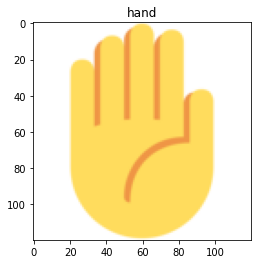

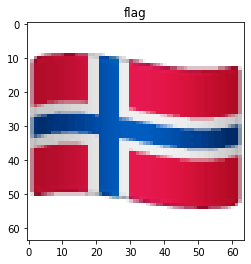

In [16]:
for image, label in train_data.dataset.take(2):
  print(image.shape)
  plt.figure()
  plt.imshow(image)
  plt.title(label_names[label])

## Model
With one line of code we can create an image classifier with our own data.
Under the hood, image_classifier.create will compile and train the model with transfer learning. By default it uses a pretrained EfficientNet-Lite0.

### Create & train the model
Create and train the model takes just one line of code `image_classifier.create()`.

Here are the defaults in the TFLite Model Maker:
* model - EfficientNet-Lite0
* Input image shape - [224, 224]
* number of epochs - 5
* batch size = 32

In [17]:
model = image_classifier.create(train_data, 
                                validation_data=validation_data, 
                                epochs = 10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                64050     
Total params: 3,477,074
Trainable params: 64,050
Non-trainable params: 3,413,024
_________________________________________________________________
None
INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Epoch 1/10
250/250 [==============================] - 18s 73ms/step - loss: 2.0990 - accuracy: 0.6304 - val_loss: 1.3274 - val_accuracy: 0.8548
Epoch 2/10
250/250 [==============================] - 18s 73ms/step - loss: 1.2557 - accuracy: 0.8813 - val_loss: 1.1298 - val_accuracy: 0.9204
Epoch 3/10
250/250 [==============================] - 18s 74ms/step - loss: 1.1257 - accuracy: 0.9211 - val_loss: 1.0622 - val_accuracy: 0.9395
Epoch 4/10
250/250 [==============================] - 19s 75ms/step - loss: 1.0670 - accuracy: 0.9417 - val_loss: 1.0268 - val_accuracy: 0.9506
Epoch 5/10
250/250 [==============================] - 19s 76ms/step - loss: 1.0364 - accuracy: 0.9488 - val_loss: 1.0045 - val_accuracy: 0.9526
Epoch 6/10
250/250 [==============================] - 20s 80ms/step - loss: 1.0094 - accuracy: 0.9579 - val_loss: 0.9900 - val_accuracy: 0.9567
Epoch 7/10
250/250 [==============================] - 21s 85ms/step - loss: 0.9901 - accuracy: 0.9655 - val_loss: 0.9780 - val_accuracy:

### Test accuracy

In [18]:
loss, accuracy = model.evaluate(test_data)

32/32 [==============================] - 2s 48ms/step - loss: 0.9729 - accuracy: 0.9660


### Visualize predictions
First we get images and labels from a test batch, and then use the retrained model to make predictions.

In [0]:
# Take 16 images from the test dataset
test_batch = test_data.dataset.take(16)

In [23]:
predictions = model.predict_top_k(test_data)
predictions[:4]

[[('drinks', 0.8915677)],
 [('envelope', 0.92339706)],
 [('feline', 0.56297696)],
 [('tree', 0.35957226)]]

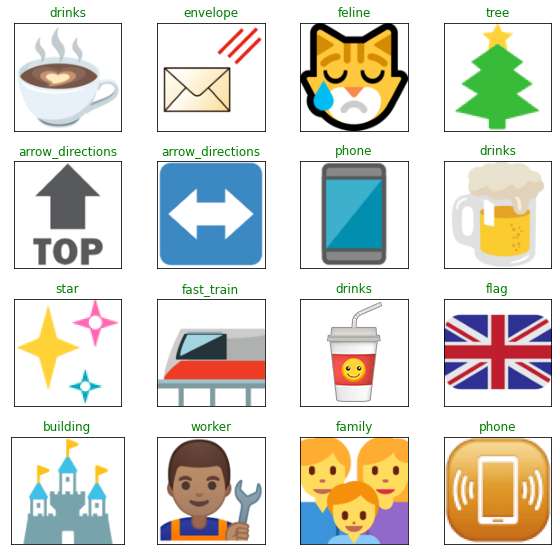

In [24]:
plt.figure(figsize=(8, 8))

# Display 16 test images with predictions
for i, (image, label_index) in enumerate(test_batch):
  plt.subplot(4, 4, i+1)
  plt.tight_layout() # add space between subplots
  plt.xticks([]) 
  plt.yticks([])
  plt.grid(False) # remove grids
  plt.imshow(image)
  prediction = str(predictions[i][0][0])
  title_color = "green" if prediction == label_names[label_index] else "red"
  plt.title(prediction, color = title_color)

### Export the model

Create model and labels file, download them from Colab left sidebar.
These files are ready to be used in mobile apps and edge devices.  

In [25]:
# Create tflite model and labels file 
model.export('model.tflite', 'labels.txt')

INFO:tensorflow:Export to tflite model in model.tflite.


INFO:tensorflow:Export to tflite model in model.tflite.


INFO:tensorflow:Saved labels in labels.txt.


INFO:tensorflow:Saved labels in labels.txt.


## Change the pretrained model

We could switch the pretrained model by just setting parameter `model_spec ` in the `image_classifier.create()` method.


#### Change to another model supported by Model Maker

The default model in the Model Maker is EfficientNet-Lite0. 

[EfficientNet-Lite](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite) are a family of image classification models that could achieve state-of-art accuracy and suitable for Edge devices. 

For now the TFLite Model Maker supports EfficientNet-Lite models, MobileNetV2 and ResNet50.  

In [0]:
# change pretrained model to EfficientNet1
model = image_classifier.create(train_data, model_spec=efficientnet_lite1_spec, validation_data=validation_data)

# change pretrained model to mobilenet v2
model = image_classifier.create(train_data, model_spec=mobilenet_v2_spec, validation_data=validation_data)

# change pretrained model to ResNet 50
model = image_classifier.create(train_data, model_spec=resnet_50_spec, validation_data=validation_data)

#### Change to another model supported on TensorFlow Hub

In [0]:
inception_v3_spec = ImageModelSpec(uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

# change to Inception V3
model = image_classifier.create(train_data, model_spec=inception_v3_spec, validation_data=validation_data)